# **The Power of a Button: Unlocking Customer Engagement through A/B Testing**

## *Table of Contents*

1. [Introduction](#Introduction)
2. [Data Preparation](#Data-Preparation)
3. [Data Segmentation](#Introduction)
4. [Analyzing Click-Through Rates (CTR)](#Analyzing-Click-Through-Rates-(CTR))
5. [Verifying Assumptions Before Statistical Testing](#Verifying-Assumptions-Before-Statistical-Testing)
6. [Hypothesis Testing: The Mann-Whitney U Test for Binary Data](#Hypothesis-Testing:-The-Mann-Whitney-U-Test-for-Binary-Data)
7. [Conclusion](#Conclusion)

## **Introduction**

### **Background**

A/B testing plays a crucial role in optimizing digital experiences, especially in today's e-commerce landscape. As retailers shift online, customer engagement through mobile apps is paramount. Loyalty programs are a key strategy to retain customers and encourage repeat purchases. Click-through rate (CTR) on digital prompts becomes a critical metric for measuring the effectiveness of these programs, particularly when it comes to driving app downloads or user registration.

### **Objective**

The primary goal of this project is to analyze the impact of a UI change on a grocery chain's website. Specifically, the dataset compares user sign-up rates between a traditional link format and a button format for initiating the loyalty program registration process. This A/B test will help determine if the UI change influences user behavior and drives a higher number of loyalty program registrations from new users. The provided dataset, collected over a one-week period, includes records of both new and existing user interactions with the website.

### **Data Source**

A/B testing plays a crucial role in optimizing digital experiences, especially for websites in the e-commerce landscape. This project utilizes a publicly available dataset from Kaggle to demonstrate the power of A/B testing in understanding user behavior and website interaction. The dataset originates from a study on user interactions with a grocery chain's website.

While conducting a large-scale A/B test can be expensive and resource-intensive, analyzing existing datasets allows us to learn valuable insights into this process. This particular dataset provides a rich resource for exploring user response to UI changes. It includes user actions meticulously logged by IP address, along with server IDs that help distinguish between the control and test groups. By analyzing user sign-ups (a key user action) within these groups, we can determine the effectiveness of a specific UI modification – in this case, comparing a link versus a button for loyalty program registration.

The dataset is available on Kaggle at https://www.kaggle.com/datasets/tklimonova/grocery-website-data-for-ab-test/data.

### **Analysis Goals**

- **Determine whether changing the loyalty program sign-up format from a hyperlink to a button leads to a statistically significant increase in the click-through rate for new users on the grocery chain's website.**
- **Provide insights into how user interface (UI) design impacts user engagement.**
- **Generate recommendations for grocery chains to improve their website design for higher engagement and conversion rates.**

This project aims to contribute to the understanding of digital marketing strategies within the retail sector. It will provide evidence-based insights to guide website design decisions and improve customer engagement tactics.


## **Data Preparation**

### **Library Imports**

Prior to conducting our AB testing analysis, we must import the required libraries to work effectively with our datasets.

#### Third-party imports

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import pandas as pd
import seaborn as sns
from scipy.stats import mannwhitneyu, shapiro
from IPython.display import Markdown

### **File Importation**

We begin by importing the Pandas library, which allows us to work with dataframes in Python. The dataset, `"ab_test_data.csv"` is then read into a dataframe called `df`.

In [2]:
# Load the dataset from a CSV file into a pandas DataFrame.
data_path = 'src/ab_test_data.csv'
df = pd.read_csv(data_path)

### **Preliminary Data Exploration**

To get a firsthand look at the data, we use the `df.head()` function to display the first few rows of the dataframe. This provides a quick overview of the column names and the types of data they contain.

In [3]:
# Display the first 5 rows of the DataFrame to get a quick overview of the data
print(df.head())

   RecordID   IP Address  LoggedInFlag  ServerID  VisitPageFlag
0         1  39.13.114.2             1         2              0
1         2    13.3.25.8             1         1              0
2         3  247.8.211.8             1         1              0
3         4  124.8.220.3             0         3              0
4         5  60.10.192.7             0         2              0


After importing the data, a review of the DataFrame's structure reveals five primary columns (variables). These columns represent the following:
| Column         | Description                                                  | Type          | Classification |
|----------------|--------------------------------------------------------------|---------------|----------------|
| `RecordID`     | Identifier of the row of data                                | Integer       | Categorical    |
| `IP Address`   | Address of the user, who is visiting website                 | String        | Categorical    |
| `LoggedInFlag` | 1 - when user has an account and logged in, 0 otherwise      | Integer (0/1) | Categorical    |
| `ServerID`     | One of the servers user was routed through                   | Integer (1/2/3) | Categorical    |
| `VisitPageFlag`| 1 - when user clicked on the loyalty program page, 0 otherwise | Integer (0/1) | Categorical    |



In [4]:
# Calculate the total number of entries (rows) in the DataFrame
number_of_entries = len(df)

# Display a formatted message indicating the total number of entries in the DataFrame
display(Markdown(f"It's worth noting that our DataFrame comprises "
                 f"**{number_of_entries}** individual entries (rows)."))

It's worth noting that our DataFrame comprises **184588** individual entries (rows).

#### **Missing Values**
Using `df.isnull().sum()`, we check for any missing values within the dataset. Missing values must be addressed before analysis, as they can impact results. Here, we confirm that the dataset has no missing values, ensuring data quality.

In [5]:
# Identify missing values across columns
print('Missing values across columns:')
print(df.isna().sum())

Missing values across columns:
RecordID         0
IP Address       0
LoggedInFlag     0
ServerID         0
VisitPageFlag    0
dtype: int64


### **Data Cleaning**


#### **Ensuring Unique User Actions per IP Address**

The dataset might contain duplicate user actions for the same IP address. We'll address this by grouping the data and prioritizing the first user interaction per IP for a cleaner analysis. The specific cleaning steps are shown in the following code snippet.

In [6]:
# Group the DataFrame by 'IP Address', 'LoggedInFlag', and 'ServerID', and calculate the sum of 'VisitPageFlag' for each group.
# The result is a new DataFrame with these groups as unique combinations and their corresponding sum of 'VisitPageFlag'.
df_ip = df.groupby(['IP Address', 'LoggedInFlag', 'ServerID'])['VisitPageFlag']\
    .sum().reset_index(name='sum_VisitPageFlag')

# Convert the sum of 'VisitPageFlag' to a binary flag where 1 indicates at least one page visit and 0 indicates no visits.
# This is done by applying a lambda function to each value in 'sum_VisitPageFlag'.
df_ip['VisitPageFlag'] = df_ip['sum_VisitPageFlag'].apply(lambda x: 1 if x != 0 else 0)

In [7]:
# Display the first 5 rows of the 'df_ip' DataFrame to preview the changes made, 
# including the new 'VisitPageFlag' binary flag column.
print(df_ip.head())

  IP Address  LoggedInFlag  ServerID  sum_VisitPageFlag  VisitPageFlag
0  0.0.108.2             0         1                  0              0
1  0.0.109.6             1         1                  0              0
2  0.0.111.8             0         3                  0              0
3  0.0.160.9             1         2                  0              0
4  0.0.163.1             0         2                  0              0


#### **Filtering for New Users**

To accurately assess the impact of the UI change on attracting new users, we need to focus our analysis specifically on potential customers interacting with the signup page for the first time. Existing loyalty program members are not relevant to this test, as they have likely already made their signup decision. 

The following code snippet will filter the dataframe to exclude existing users.  Let's explain why this filtering step is necessary:

* **Accuracy:**  Including existing users could skew results.  Their behavior might not reflect how first-time visitors respond to the UI change. 
* **Focus:** This filter ensures our analysis aligns with the A/B test's objective, which is specifically about attracting new users to the loyalty program. 


In [8]:
# Filter the 'df_ip' DataFrame to retain only the rows where 'LoggedInFlag' is 0.
# This operation ensures that the DataFrame now only includes new users who have not logged in.
df_ip = df_ip[df_ip['LoggedInFlag'] == 0]

### **Feature Engineering**

#### **Assigning Testing/Control Groups**

The dataset currently doesn't explicitly identify which users belong to the testing or control groups. We know the A/B test design allocated roughly one-third of users to the testing group and two-thirds to the control group. This allocation was determined by 'ServerID' – users who connected through specific server IDs were assigned to either the testing or control group.

Yes, you're absolutely right about several aspects of A/B testing design!  Here's how you can incorporate these points into your description, along with some additional considerations:

**Rationale for Split:**

A 1:2 allocation ratio (one-third test, two-thirds control) is common in A/B testing for several reasons:

* **Statistical Significance:** A larger control group provides a more robust baseline for comparison. This ensures that observed differences are more likely statistically significant (less likely due to random chance).
* **Real-World Representation:** A 2:1 ratio can closely reflect real-world website traffic patterns, where new features may be rolled out gradually to a smaller portion of users before full adoption.
* **Mitigation of Risk:** If the new feature unexpectedly has a negative effect, it impacts a smaller portion of users in the test group.

**Additional Considerations:**

* While 1:2 is common, the specific split may change depending on the context of the test and the level of risk involved for the company.
* In some cases, multiple test groups may be used with even smaller percentages to compare variations of the UI change.

In [9]:
# Map 'ServerID' values to group categories. Servers with ID 1 are categorized as 'Testing',
# while servers with IDs 2 and 3 are categorized as 'Control'. This mapping is applied to 
# create a new column 'group' in the 'df_ip' DataFrame.
df_ip['group'] = df_ip['ServerID'].map({
    1: 'Testing',
    2: 'Control',
    3: 'Control'
})

## **Data Segmentation**

#### **Creating Separate Test and Control Dataframes**

While our dataset includes a column identifying test and control groups, we'll improve the analysis workflow by creating separate dataframes for each group. This will streamline our exploration and calculations when conducting the A/B test.

In [10]:
# Separate the 'df_ip' DataFrame into two new DataFrames based on the 'group' column:
# one for 'Control' and another for 'Testing'. This helps in analyzing these groups separately.

# Create a DataFrame for entries in the 'Control' group and reset its index for continuity.
control = df_ip[df_ip['group'] == 'Control'].copy()
control.reset_index(inplace=True, drop=True)

# Create a DataFrame for entries in the 'Testing' group and reset its index for continuity.
testing = df_ip[df_ip['group'] == 'Testing'].copy()
testing.reset_index(inplace=True, drop=True)

#### **Control and Testing Group Sample Sizes**

In [21]:
# Print the sample sizes for the 'control' and 'testing' groups to verify
# the number of observations in each group for A/B testing purposes.

print(f'Sample size for Control group: {len(control)}')
print(f'Sample size for Testing group: {len(testing)}')

Sample size for Control group: 32970
Sample size for Testing group: 16543


**Why Sample Size Matters in A/B Testing**

For this project, we have a large dataset that provides ample data points for our control and testing groups:

* **Control group** sample size: **32970**
* **Testing group** sample size: **16543**

In A/B testing, a larger sample size brings several key benefits that strengthen the reliability and interpretability of our findings. Here's why:

**1. Statistical Power and Detecting True Differences:** Larger sample sizes increase our statistical power, which is the ability to confidently detect a true difference between groups if one exists. With more data points, we reduce the risk of falsely concluding that there's no difference (false negative) when a real effect might be present. In this project, the substantial control and testing group sizes provide us with the necessary power to identify even subtle changes in customer behavior.

**2. Representativeness and Generalizability:**  Ideally, our sample should be representative of the broader population we wish to understand (in this case, all potential grocery shoppers).  Larger sample sizes tend to better reflect the diversity and variability within the population, making it more likely that the patterns observed in our sample hold true for the wider user base.  

**3. Reliability of Estimates and Minimizing Variability:** A larger sample size reduces random variability (noise) within each group. This leads to tighter confidence intervals around our key metrics (like click-through rate).  With reliable estimates, we gain a clearer picture of the true impact of the UI change.  

**4. Informing Test Selection:** Sample size plays a key role in choosing the appropriate statistical test for analysis.  Some tests have assumptions about sample size, and a sufficiently large sample allows us to use more robust techniques, enhancing the validity of our conclusions. 

**5. Projecting Impact to Population:** With a 2:1 control to testing ratio and large sample sizes, we can more confidently project the potential impact of the UI change if implemented across the entire customer base. A smaller sample could result in an inflated estimate of the effect size and misrepresent the true impact on the wider business.

**In conclusion, the large sample sizes in this project enhance the validity and robustness of our results. They allow us to detect meaningful differences with confidence, generalize our findings, and make informed business decisions based on our A/B test.**

## **Analyzing Click-Through Rates (CTR)**

**Click-through rate (CTR)** is a key metric that indicates the effectiveness of the signup prompt (link or button) in attracting users. It is calculated as the percentage of users who clicked on the signup prompt divided by the total number of users who viewed the page. In this section, we will calculate the CTR for both the test and control groups to compare the performance of the button versus the link.

### **Calculate CTR for the 'Control' group.**

In [11]:
# Count the total number of page views in the 'Control' group.
control_view = control['VisitPageFlag'].count()

# Count the number of clicks (VisitPageFlag == 1) in the 'Control' group.
control_click = control[control['VisitPageFlag'] == 1]['VisitPageFlag'].count()

# Calculate the Click-Through Rate (CTR) for the 'Control' group as a percentage.
control_ctr = (control_click / control_view) * 100

### **Calculate CTR for the 'Testing' group.**

In [12]:
# Count the total number of page views in the 'Testing' group.
testing_view = testing['VisitPageFlag'].count()

# Count the number of clicks (VisitPageFlag == 1) in the 'Testing' group.
testing_click = testing[testing['VisitPageFlag'] == 1]['VisitPageFlag'].count()

# Calculate the Click-Through Rate (CTR) for the 'Testing' group as a percentage.
testing_ctr = (testing_click / testing_view) * 100

### **Visualizing and Comparing CTRs.**


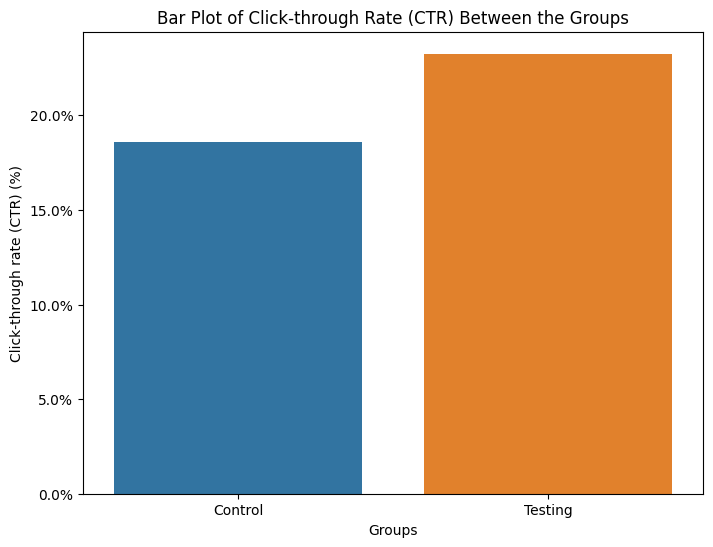

In [13]:
ctr = pd.DataFrame({
    'Groups': ['Control', 'Testing'],
    'Click-through rate (CTR) (%)': [control_ctr, testing_ctr]
})


# Create a DataFrame to hold CTR data for 'Control' and 'Testing' groups.
ctr = pd.DataFrame({
    'Groups': ['Control', 'Testing'],
    'Click-through rate (CTR) (%)': [control_ctr, testing_ctr]
})

# Set up the figure for plotting.
plt.figure(figsize=(8, 6))

# Create a bar plot showing the CTR for each group.
# 'hue' parameter is used to color bars based on the group.
sns.barplot(data=ctr, x='Groups', y='Click-through rate (CTR) (%)', hue='Groups')

# Format the y-axis to display percentages.
plt.gca().yaxis.set_major_formatter(PercentFormatter())

# Set the title of the plot.
plt.title('Bar Plot of Click-through Rate (CTR) Between the Groups')

# Display the plot.
plt.show()

In [14]:
# Print the Click-Through Rate (CTR) for both the Control and Testing groups,
# rounding the values to two decimal places for clarity.

print(f'Control Group CTR: {round(control_ctr, 4)}%')
print(f'Testing Group CTR: {round(testing_ctr, 4)}%')

Control Group CTR: 18.5957%
Testing Group CTR: 23.2545%


**Beyond Click-Through Rates: Statistical Testing for Significance**

While the initial CTR comparison suggests that the test group (button format) might be outperforming the control group (link format), we need a more in-depth analysis to draw meaningful conclusions. Direct CTR comparisons can be misleading for several reasons:

**1. Sample Size Considerations**

The sample sizes in our test and control groups are different. Sample size differences can impact the reliability of our comparison. A very high CTR with a small sample size might not be as compelling as a slightly lower CTR observed within a larger sample. 

**2. Statistical Testing for Significance**

Directly comparing the rates gives us a starting point, but it doesn't reveal whether the observed difference is statistically significant or simply due to chance. To make definitive conclusions, we need to conduct a statistical test. These tests factor in both the CTRs and the sample sizes of each group, determining if the difference we see is likely due to the UI change or if it could have occurred by random variation.

**3. Limitations of CTR**

Even if the CTR is higher in the test group, this metric alone provides limited insights. CTR only captures clicks, but what happens after the click? We need to consider whether users are engaging with the content after clicking or quickly bouncing back. Focusing solely on CTR doesn't provide this nuanced view of user behavior.

**In Conclusion**

Click-through rates offer a valuable starting point in A/B testing analysis. However, to make informed decisions and ensure the observed differences are not due to chance or other factors, we need to use statistical testing. This next phase will determine the statistical significance of the CTR difference, providing a robust foundation for conclusions about the impact of our UI change. 


## **Verifying Assumptions Before Statistical Testing**

Before applying a specific statistical test to our A/B testing data, it's crucial to verify that the data meets the underlying **assumptions** of the test. This ensures the **validity** and **reliability** of our results.  Here's a breakdown of the key assumption checks:

**1. Checking for Normality**

* **Why it matters:** Many statistical tests, particularly **parametric tests**, assume that the data follows a **normal distribution** (bell-shaped curve).
* **Test example:** **Shapiro-Wilk test** is a common test used to assess normality.
* **Outcome:**
    * If the data is **normally distributed** (passes the Shapiro-Wilk test), we can proceed with parametric tests (e.g., **t-test**) which are generally more powerful.
    * If the data is not normally distributed (fails the Shapiro-Wilk test), we should consider **non-parametric tests** which are less reliant on specific data distributions.

**2. Homogeneity of Variance**

* **What it means:** This refers to the assumption that the **variances** (spread) of the data in each group (control and test) are approximately equal.
* **Why it matters:** Unequal variances can affect the validity of certain parametric tests.
* **Test example:** **Levene's test** is commonly used to assess homogeneity of variance.
* **Outcome:**
    * If the variances are equal (passes Levene's test), we can proceed with the chosen parametric test (e.g., t-test).
    * If the variances are unequal (fails Levene's test), we can still use a parametric test, but we need to adjust it to account for the unequal variances (e.g., **Welch's t-test**). Alternatively, we can choose a non-parametric test.

**Choosing the Right Test:**

The decision of which test to use (parametric or non-parametric) ultimately depends on the outcome of the assumption checks:

* **If the data is normally distributed and has equal variances:** A parametric test (e.g., t-test) is generally preferred due to its increased power.
* **If the data is not normally distributed or has unequal variances:** A non-parametric test (e.g., **Mann-Whitney U test**) is a more suitable choice.

**Summary**

By performing these assumption checks, we ensure that the chosen statistical test is appropriate for our data. This helps us draw more reliable conclusions from our A/B testing analysis. 


### **The Shapiro-Wilk Test for Normality**

The **Shapiro-Wilk test** is a powerful **statistical test** for assessing whether a sample dataset likely came from a **normally distributed** population. It's particularly well-suited for larger sample sizes, although it also works effectively for smaller samples.

**How It Works:**

The Shapiro-Wilk test compares the sample data to a theoretically perfect **normal distribution**. It calculates a test statistic called **W**, which measures how closely the sample data matches the expected values of a normal distribution. 

* **W = 1:** This indicates perfect normality.
* **W < 1:** The further W is from 1, the stronger the evidence that the data deviates from normality.

Along with the W statistic, the test provides a **p-value** which is key for interpreting the results.

**Hypothesis Testing**

To interpret the Shapiro-Wilk test, we establish a **null hypothesis** and an **alternative hypothesis**:

* **Null Hypothesis (H0):** Our data *follows* a normal distribution (p-value > 0.05) 
* **Alternative Hypothesis (H1):** Our data *significantly deviates* from a normal distribution (p-value ≤ 0.05) 

**Interpreting Results**

* **If the p-value > 0.05:** We fail to reject the null hypothesis. This suggests our data is consistent with a normal distribution, and we can potentially use **parametric tests**.
* **If the p-value ≤ 0.05:** We reject the null hypothesis. This indicates that our data likely does not follow a normal distribution, and we should consider using **non-parametric tests**.

**In A/B Testing:**

When conducting A/B testing, we will apply the Shapiro-Wilk test separately to both the control and test groups. The results of these tests will guide our choice of statistical techniques for comparing the groups, ensuring the tests we use are appropriate for our data.

**Control Group**

In [15]:
# Perform the Shapiro-Wilk test for normality on the 'VisitPageFlag' column
# of the control group DataFrame.

test_stat_n_c, pvalue_n_c = shapiro(control['VisitPageFlag'])
print('Control Group:')
print(f'Test Stat = {test_stat_n_c}, p-value = {pvalue_n_c}')

Control Group:
Test Stat = 0.4737101547180562, p-value = 1.1748980623063197e-131


C:\Users\AAA\AppData\Local\Temp\ipykernel_27256\2124012019.py:4: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 32970.
  test_stat_n_c, pvalue_n_c = shapiro(control['VisitPageFlag'])


**Testing Group**

In [16]:
# Perform the Shapiro-Wilk test for normality on the 'VisitPageFlag' column
# of the testing group DataFrame

test_stat_n_t, pvalue_n_t = shapiro(testing['VisitPageFlag'])
print('\nTesting Group:')
print(f'Test Stat = {test_stat_n_t}, p-value = {pvalue_n_t}')


Testing Group:
Test Stat = 0.5230118575503322, p-value = 7.76673660554752e-110


C:\Users\AAA\AppData\Local\Temp\ipykernel_27256\2829364952.py:4: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 16543.
  test_stat_n_t, pvalue_n_t = shapiro(testing['VisitPageFlag'])


**Shapiro-Wilk Test Results**

The Shapiro-Wilk tests conducted on both the control and testing groups yielded p-values less than 0.05. This indicates that we **reject the null hypothesis** for both groups. In other words, there's strong evidence that the data in each group does not follow a normal distribution. 

**Implications for A/B Testing**

Since our data does not meet the normality assumption, it's more appropriate to use a non-parametric test. The **Mann-Whitney U test** is a suitable choice as it's designed for comparing two independent samples without requiring a normal distribution. 


## **Hypothesis Testing: The Mann-Whitney U Test for Binary Data**

Since our previous normality tests (Shapiro-Wilk) showed that our groups' data is not normally distributed, we'll use the **Mann-Whitney U test**. While the Mann-Whitney U test typically compares the **medians** of two independent groups, when dealing with **binary data** (like clicks vs. no clicks in our case), the interpretation is slightly different. Here, the test assesses whether the distributions of **0s (no clicks)** and **1s (clicks)** differ significantly between the control and test groups. 

**How the Mann-Whitney U Test Works with Binary Data**

1. **Combined Ranking:** All observations (clicks and no clicks) from both groups are combined and ranked together from lowest to highest.
2. **Handling Ties:** If multiple observations have the same value (ties), they receive the average rank of the positions they would occupy if there were no ties. With binary data, ties are common (all the 0s or all the 1s) and this averaging ensures a fair ranking.
3. **Rank Sums:** The ranks of observations within each group (control and test) are summed up separately.
4. **The 'U' Statistic:** A 'U' statistic is calculated for each group, representing the number of times an observation from one group precedes an observation from the other group in the ranking.
5. **Smaller 'U' Value:** The smaller of the two 'U' values becomes the official Mann-Whitney U test statistic. 
6. **Significance:** Based on sample sizes and the calculated 'U' value, we determine the probability (p-value) of getting a result as extreme or more extreme than what we observed if there were truly no difference between the groups (the null hypothesis).

**Assumptions for the Mann-Whitney U Test**

* **Independence:** The two samples (control and test groups) must be independent of each other. 
* **Ordinal Data:** The data must be at least ordinal, meaning we can classify observations as "no click" (0) or "click" (1). 
* **Sample Size:** While there's no strict minimum, larger sample sizes (20+ per group) increase the power of the Mann-Whitney U test to detect meaningful differences.

**Hypotheses**

* **Null Hypothesis (H0):** The distribution of **binary outcomes (clicks)** is the same for both groups (p-value > 0.05). In our case, this would mean the UI change (button vs. link) had no impact on signup rates (clicks).
* **Alternative Hypothesis (H1):** The distribution of **binary outcomes** differs between the two groups (p-value ≤ 0.05). This suggests the UI change likely influenced signup rates, but it doesn't indicate whether the button or link performed better.

**Advantages of the Mann-Whitney U Test**

This test is valuable when comparing independent groups, especially when parametric test assumptions like normality are not met. It allows researchers to identify differences between groups without relying strictly on normal distributions. This makes it a powerful and versatile tool in statistical analysis.

### **Performing the Mann-Whitney U Test**

In [17]:
# Perform the Mann-Whitney U test to compare the distribution of 'VisitPageFlag' 
# between the control and testing groups.

test_stat_np, pvalue_np = mannwhitneyu(control["VisitPageFlag"],
                                       testing["VisitPageFlag"])

### **Results and Interpretation of the Mann-Whitney U Test**

In [18]:
# Print the results of the Mann-Whitney U Test to compare the 'VisitPageFlag'
# distribution between the control and testing groups.

print('\nMann-Whitney U Test Results:')
print(f'Mann-Whitney U Test Stat = {test_stat_np}, p-value = {pvalue_np}')


Mann-Whitney U Test Results:
Mann-Whitney U Test Stat = 260006126.5, p-value = 3.5327103972171946e-34


The Mann-Whitney U test results show an extremely small p-value of 3.5327103972171946e-34 (approximately 0.0). This indicates strong evidence against the null hypothesis. Since our chosen significance level (alpha) is typically set at 0.05 and our p-value is significantly **less than alpha**, we confidently **reject the null hypothesis**.

**Interpretation:** 

By rejecting the null hypothesis, we can conclude that the distributions of clicks (0s and 1s) between the control and test groups are statistically different. In other words, there's a statistically significant difference in how often users clicked to sign up for the Loyalty program based on whether they were presented with a hyperlink or a button.

**Considering the CTR Results:**

We also observed a difference in **Click-Through Rates (CTRs)** between the two groups. The test group with the button had a CTR of **23.26%**, whereas the control group with the hyperlink had a CTR of **18.60%**.

**Combining the Findings:**

The statistically significant difference revealed by the Mann-Whitney U test (p-value = 0.0) supports the observed difference in CTRs. We can now confidently say that the implementation of the button likely led to a **higher signup rate** for the Loyalty program compared to the hyperlink. The button resulted in a **4.66%** increase in the CTR for signing up for the Loyalty program compared to the hyperlink.

## **Conclusion**

This project provided valuable insights into the impact of UI changes on customer engagement within a grocery store website. We successfully analyzed click-through rates (CTRs) to assess the effectiveness of a button compared to a hyperlink for promoting Loyalty program signups.

The Mann-Whitney U test confirmed a statistically significant difference (p-value = 0.0) in click behaviors between the control and test groups. Furthermore, the observed difference in CTRs (button: 23.26%, hyperlink: 18.60%) was statistically significant. The button resulted in a **4.66% increase** in the CTR for signing up for the Loyalty program compared to the hyperlink.

These findings demonstrate that even seemingly minor UI adjustments can significantly influence customer actions. In this case, a simple button change led to a measurable rise in Loyalty program signups, potentially indicating a stronger connection with customers. This project highlights the potential for A/B testing and data analysis to optimize website design and enhance customer engagement within the grocery sector.

**Additional Considerations:**

* Beyond the immediate results, this project has fostered a deeper understanding of hypothesis testing and A/B testing methodologies. These valuable skills can be applied to future website optimizations and marketing initiatives.
* The detailed explanations provided throughout this report aim to ensure clarity and comprehension for any reader, regardless of their prior A/B testing knowledge.

**Overall, this project proved to be a successful exploration of UI change, customer engagement, and the power of data-driven decision making in the context of grocery store websites.**